# This script is to play a bit with the SHAP method (https://shap.readthedocs.io/en/stable/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html) with the hope to understand the causal relationship/correlation between the molecular descriptors and the aggregation kinetics

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost
import shap

### Classification

Note, since the SHAP method example used the classification algorithm, to copy its process, here an extra column was added to the excel file (mean_rmsf_nc_sasa_agg_total_sasa_temp_hbond151123.xlsx) to offer classifier. Any lnv values bigger than 3 is classified as 1, otherwise it will be 0.

In [2]:
# defination from SHAP method https://shap.readthedocs.io/en/stable/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html

class FixableDataFrame(pd.DataFrame):
    """ Helper class for manipulating generative models.
    """
    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super(FixableDataFrame, self).__init__(*args, **kwargs)
    def __setitem__(self, key, value):
        out = super(FixableDataFrame, self).__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super(FixableDataFrame, self).__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out

def fit_xgboost(X, y):
    """ Train an XGBoost model with early stopping.
    """
    X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y)
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    model = xgboost.train(
        { "eta": 0.001, "subsample": 0.5, "max_depth": 2, "objective": "reg:logistic"}, dtrain, num_boost_round=200000,
        evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=False
    )
    return model

In [3]:
# read the excel file that contains all the molecular features (13 molecular features, two Y variables)

df = pd.read_excel("mean_rmsf_nc_sasa_agg_total_sasa_temp_hbond151123.xlsx")

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Condition                                  49 non-null     object 
 1   Number of hydrogen bonds in the last 50ns  49 non-null     float64
 2   Non_polar SASA                             49 non-null     float64
 3   Total SASA                                 49 non-null     float64
 4   Average native contact (last 50ns)         49 non-null     float64
 5   r_31-36                                    49 non-null     float64
 6   r_47-51                                    49 non-null     float64
 7   r_114-118                                  49 non-null     float64
 8   r_129-139                                  49 non-null     float64
 9   r_261-265                                  49 non-null     float64
 10  r_325-329                   

In [38]:
df

,Condition,Number of hydrogen bonds in the last 50ns,Non_polar SASA,Total SASA,Average native contact (last 50ns),r_31-36,r_47-51,r_114-118,r_129-139,r_261-265,...,r_387-402,sum_aprsasa,mean RMSF,Tm,ln(v),Number,temp,IS,pH,Classifier
0,7_296_250,302.785667,229.587025,291.186722,0.181264,0.615936,0.384994,-0.047418,0.036828,0.218955,...,0.135321,1.301001,0.141087,77.927767,-6.083580,12,296,250,7.0,0
1,3_5_277_0,299.118000,228.906489,289.970744,0.213763,0.372220,0.023772,0.248029,0.184549,-0.106773,...,0.584502,1.380934,0.137486,73.701367,-5.945103,1,277,0,7.0,0
2,277_3_5_150M,305.153667,227.936189,287.330190,0.213240,0.147361,0.167100,0.105052,0.113893,0.084247,...,-0.112207,0.466692,0.128550,61.849600,-5.361700,16,277,150,7.0,0
3,277K_7_150M,299.323333,236.798943,298.890105,0.222808,0.451208,0.129987,0.384401,0.632086,0.189677,...,1.052909,3.522407,0.140163,78.629800,-5.324000,43,277,150,7.0,0
4,277K_7_250M,298.963667,233.393250,294.075131,0.198191,0.769024,0.237256,0.010192,0.525691,-0.024223,...,0.223094,2.219689,0.134526,77.927800,-4.860800,38,277,250,7.0,0
5,8_277_100,296.767333,229.544890,291.911681,0.228955,0.425250,-0.041570,0.431006,0.300900,0.006223,...,0.067980,1.189405,0.135151,77.345467,-4.823917,32,277,100,7.0,0
6,7_296_50,301.660667,237.154328,299.089239,0.229834,0.545131,0.236059,0.471578,0.664965,0.242840,...,0.308732,2.616084,0.141350,77.966067,-4.651002,40,296,50,7.0,0
7,296K_7_50M,302.171333,227.558598,289.385838,0.203910,0.150209,0.082233,0.106338,-0.214087,0.246922,...,-0.174400,0.277970,0.146066,77.966100,-4.651000,9,296,50,7.0,0
8,3_5_277_50,301.537333,225.952698,287.291211,0.208226,0.373968,0.244099,0.102368,0.128406,0.101589,...,0.063959,0.964329,0.131624,64.945700,-4.382091,8,277,50,7.0,0
9,4_5_296_250,298.405000,241.771463,304.251571,0.222016,0.661202,0.293401,0.436353,0.503143,0.339889,...,0.198846,2.818418,0.150951,73.072733,-4.193857,10,296,250,4.5,0


In [4]:
# define X variables

X = df.drop(['Condition','Number','temp','IS','pH','Tm','ln(v)','Classifier'],axis = 1)

# define y varialbe

y = df['Classifier']

model = fit_xgboost(X, y)

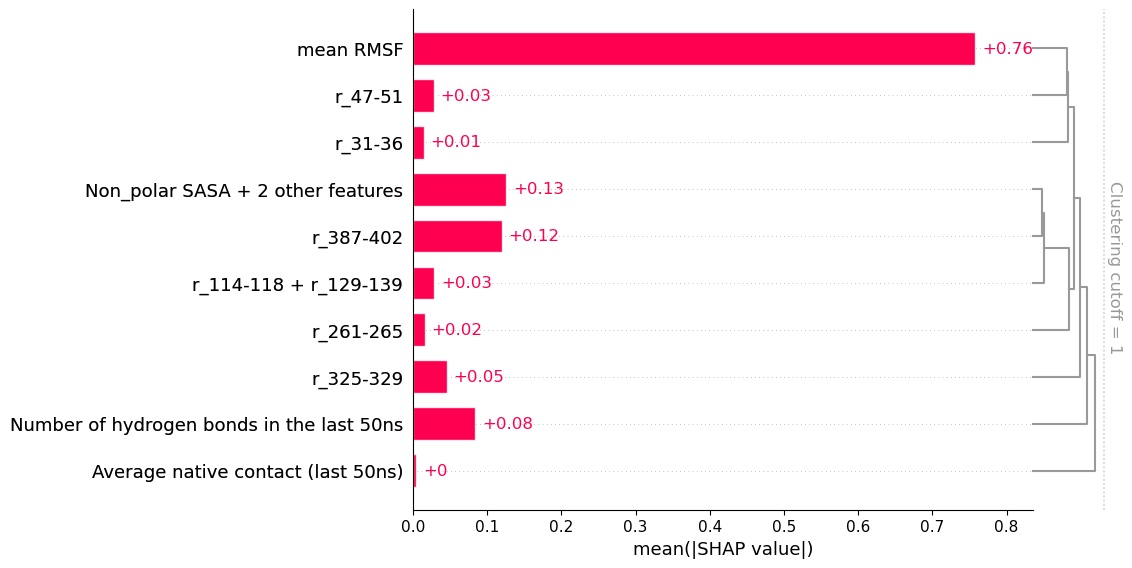

In [66]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

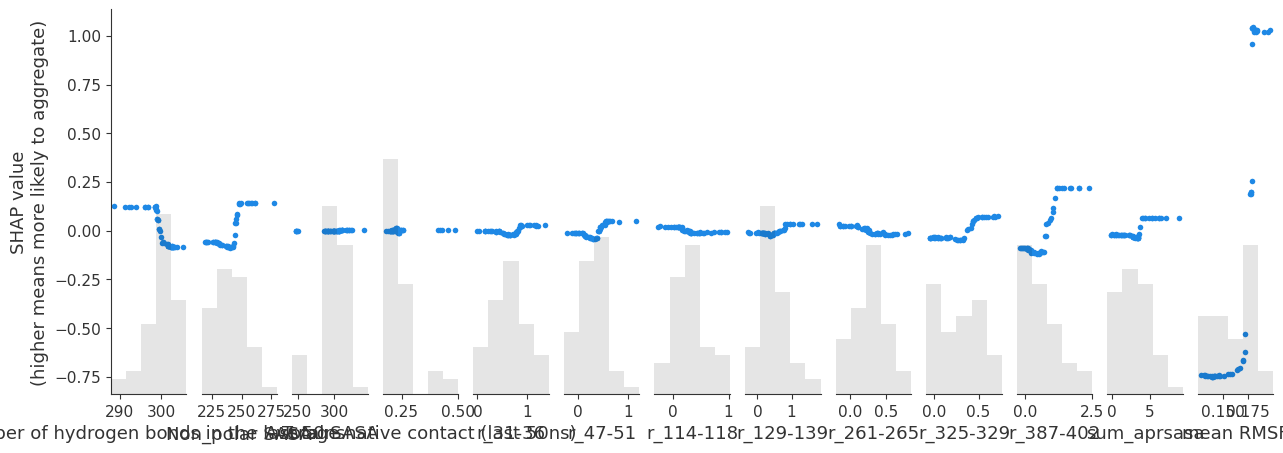

In [67]:
import matplotlib.pyplot as plt

shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to aggregate)")


#### Remove mean RMSF as feature since it largely impacts the model

In [9]:
# define X variables

X = df.drop(['Condition','Number','temp','IS','pH','Tm','ln(v)','Classifier','mean RMSF'],axis = 1)

# define y varialbe

y = df['Classifier']

model = fit_xgboost(X, y)


# Make predictions on the test set
y_pred = model.predict(X)

# Calculate the R-squared value
r_squared = r2_score(y, y_pred)

# Print or use the R-squared value as needed
print("R-squared value:", r_squared)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the XGBoost model on the training set
model = fit_xgboost(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the R-squared value
r_squared = r2_score(y_test, y_pred)

# Print or use the R-squared value as needed
print("R-squared value:", r_squared)


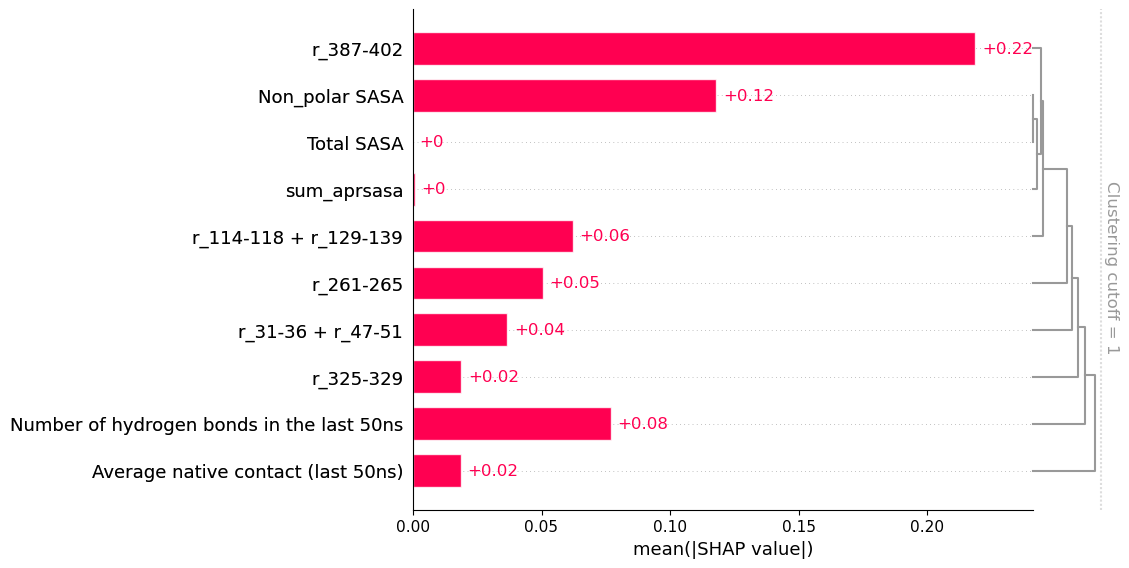

In [46]:
# define X variables

X = df.drop(['Condition','Number','temp','IS','pH','Tm','ln(v)','Classifier','mean RMSF'],axis = 1)

# define y varialbe

y = df['Classifier']

model = fit_xgboost(X, y)


import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

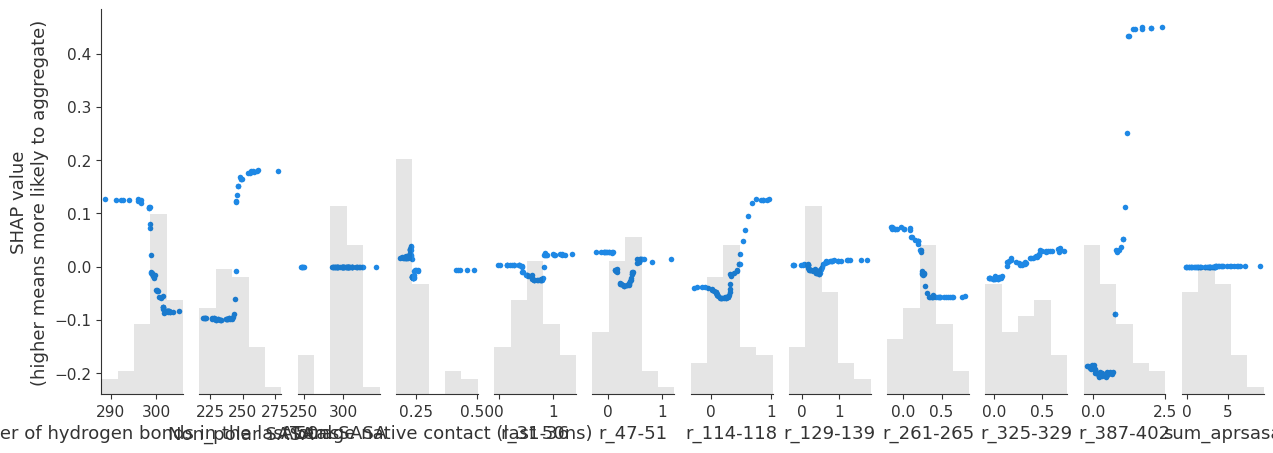

In [60]:
import matplotlib.pyplot as plt

shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to aggregate)")


To interpret how important this model is, it depends on what the goal is. If the goal is to predict aggregation kinetics based on the input formulation conditions then this model is useful and perhaps good enough.
But if the goal is at a higher level, such as at the level of protein engineering or antibody design, which requires the knowledge of deciding manipulating which features will cause a change in the aggregation rates, then this model is not sufficient, since there might be a possibility that it only captures the correlation between variables and target but they do not necessarily have causal relationship 
- I do think Paul perhaps is more interested in the latter, to build up a model that is focused on causal tasks whereas Hywel emphasizes much more the former.


I would say this is a very important plot.

It digs deeper into the possible causal relationships by changing the value of each feature to examine the impact of the changes on the model's prediction.

SHAP scatter plots show how changing the value of a feature impacts the model’s prediction of renewal probabilities. If the blue dots follow an increasing pattern, this means that the larger the feature, the higher is the model’s predicted aggregation probability.

- Hmmmm I want to adjust the font size of the x labels so they are not overlapping. I wonder how to do it. I have tried sevearl methods but didn't work

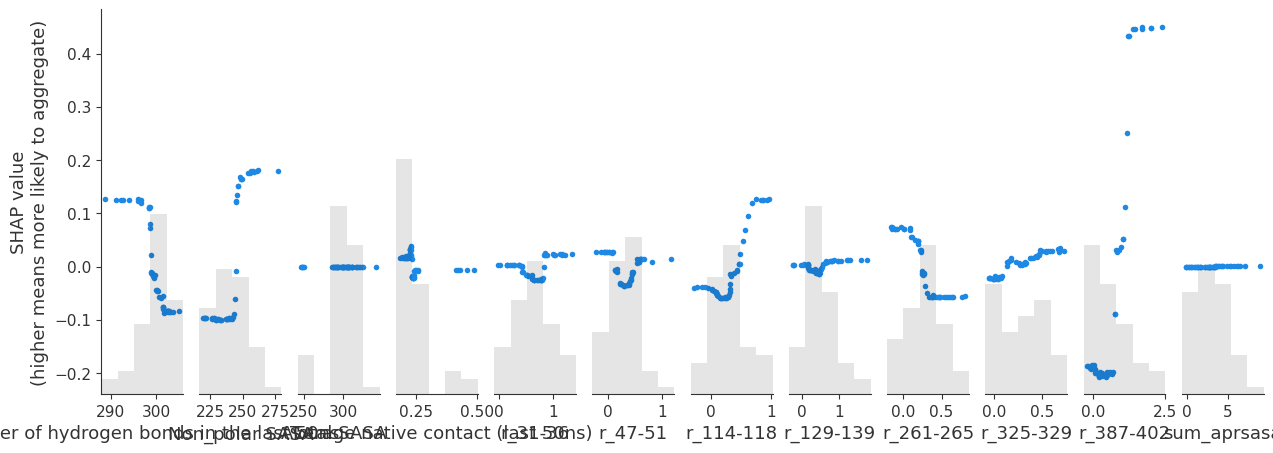

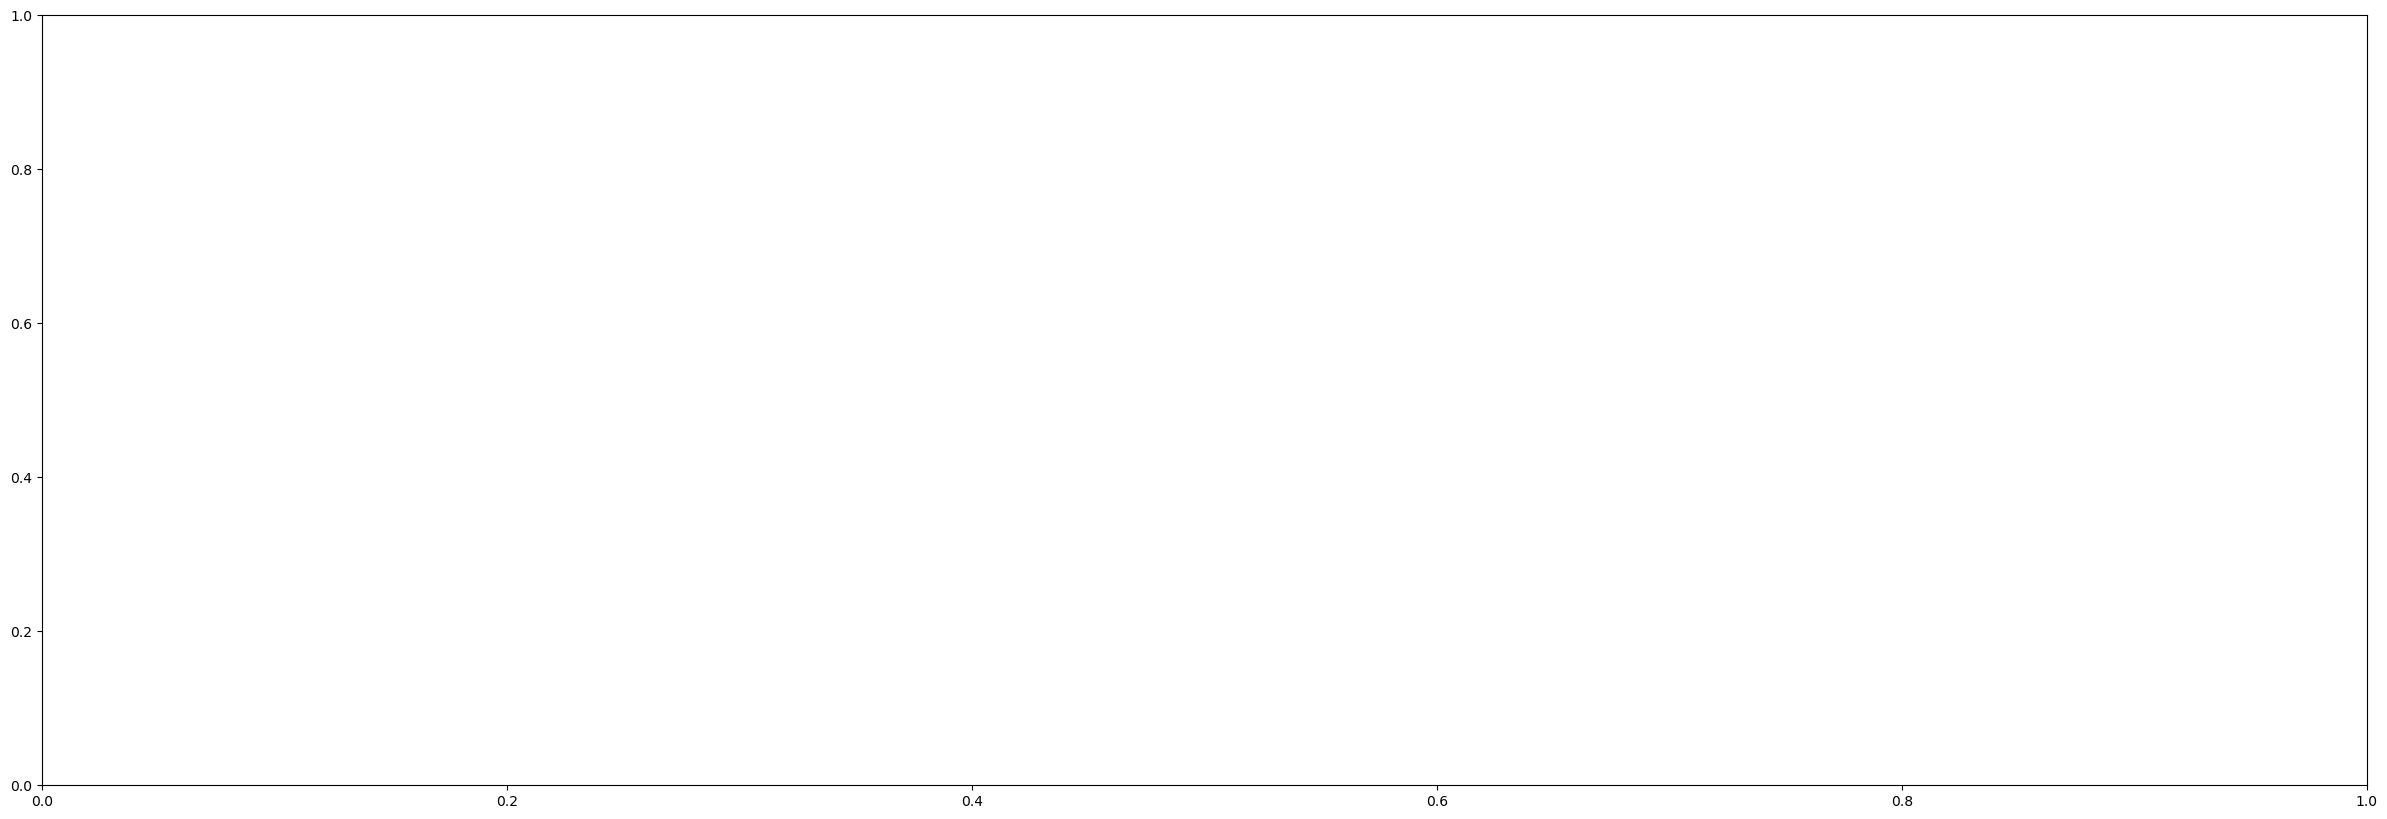

In [64]:
# doesn't work

import matplotlib.pyplot as plt

shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to aggregate)")

fig = plt.gcf()
ax = plt.gca()

fig.set_figheight(10)
fig.set_figwidth(30)

plt.savefig('shap_scatter_plot151123.png', dpi=300)  # You can adjust the file name and dpi as needed

In [ ]:
# shap.summary_plot(shap_values_DT, data_train, color=plt.get_cmap("tab10"), show=False)
# fig = plt.gcf()
# fig.set_figheight(12)
# fig.set_figwidth(14)
# ax = plt.gca()
# ax.set_xlabel(r'durchschnittliche SHAP Werte $\vert\sigma_{ij}\vert$', fontsize=16)
# ax.set_ylabel('Inputparameter', fontsize=16)
# ylabels = string_latexer([tick.get_text() for tick in ax.get_yticklabels()])
# ax.set_yticklabels(ylabels)
# leg = ax.legend()
# for l in leg.get_texts(): l.set_text(l.get_text().replace('Class', 'Klasse'))
# plt.show()

# might be useful for the aforementioned needs

## Add net charges - Update 30/11/23 - No Hbonds

In [3]:
# read file

data = pd.read_excel("mean_rmsf_nc_sasa_agg_total_sasa_temp_hbond_charges301123.xlsx",index_col=0)

[17:06:28] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No/low signal found from feature 7 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


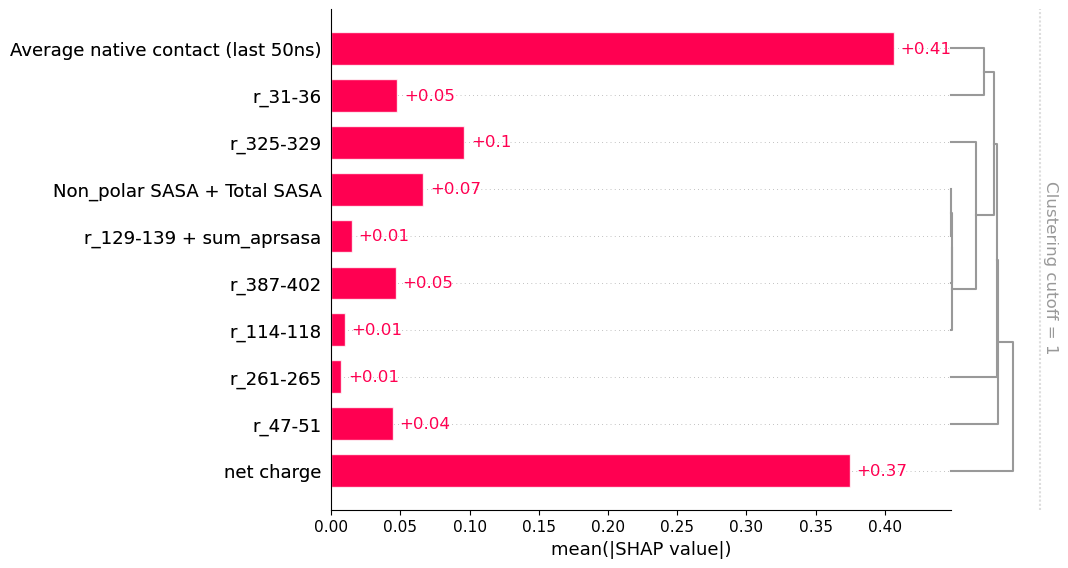

In [7]:
# define X variables

X = data.drop(['Condition','Number','temp','IS','pH','Tm','ln(v)','Classifier','mean RMSF'],axis = 1)

# define y varialbe

y = data['Classifier']

model = fit_xgboost(X, y)


import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

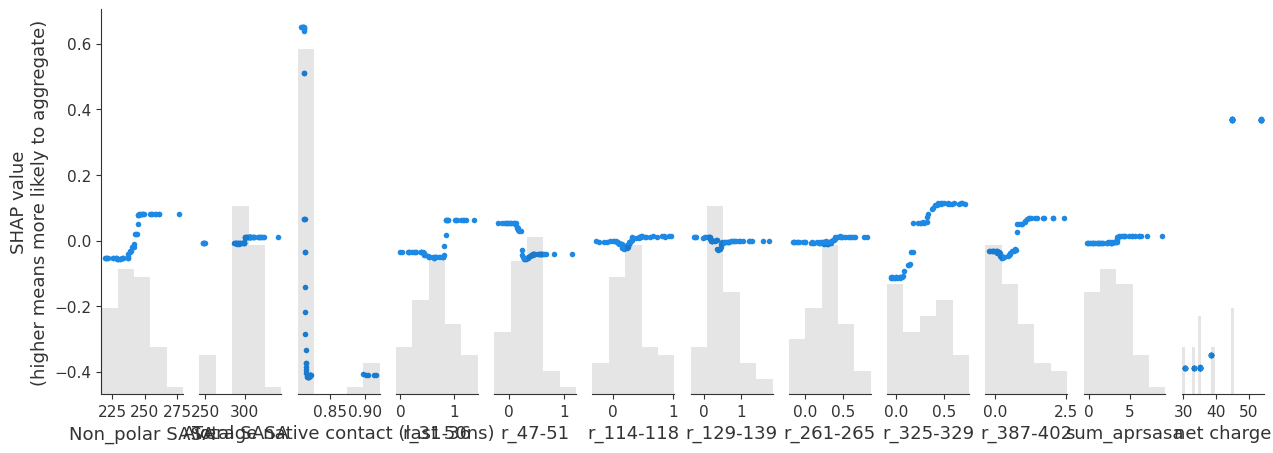

In [8]:
import matplotlib.pyplot as plt

shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to aggregate)")


## Hbonds & net charge

[18:02:14] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


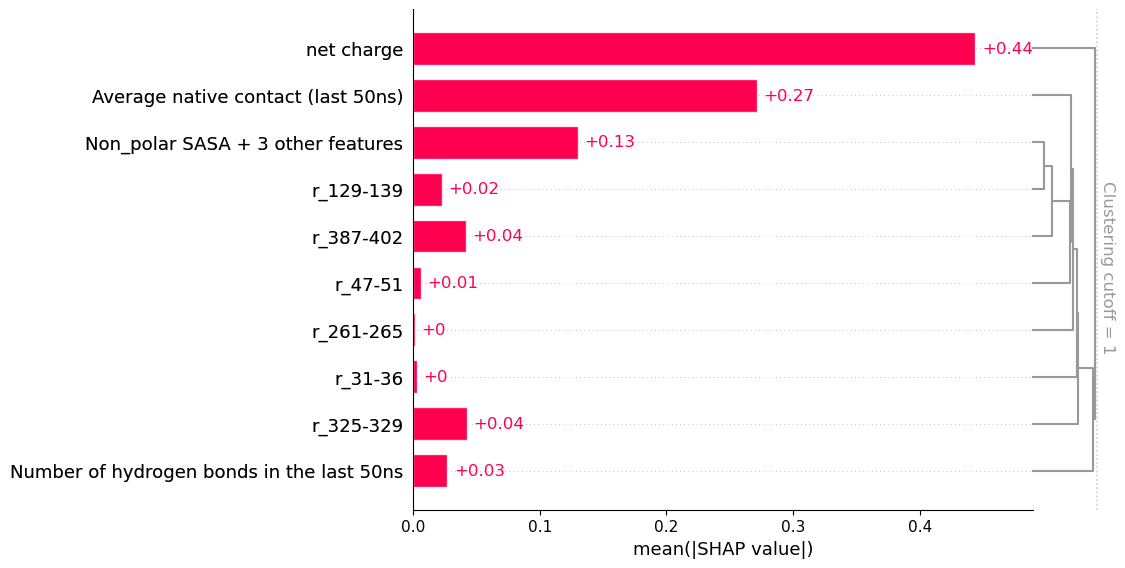

In [4]:
# read file

data = pd.read_excel("mean_rmsf_nc_sasa_agg_total_sasa_temp_hbond_charges_2_301123.xlsx",index_col=0)

# define X variables

X = data.drop(['Number','temp','IS','pH','Tm','ln(v)','Classifier','mean RMSF'],axis = 1)

# define y varialbe

y = data['Classifier']

model = fit_xgboost(X, y)


import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

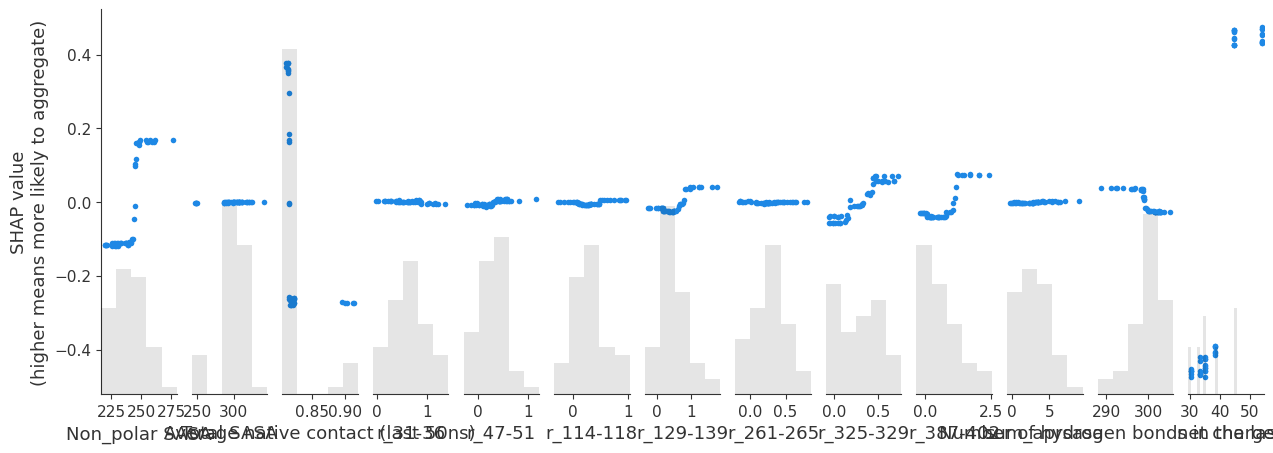

In [5]:
import matplotlib.pyplot as plt

shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to aggregate)")


## Update 08/12/2023 - net charge & Hbonds, after Paul corrected the net charge calculation

[10:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


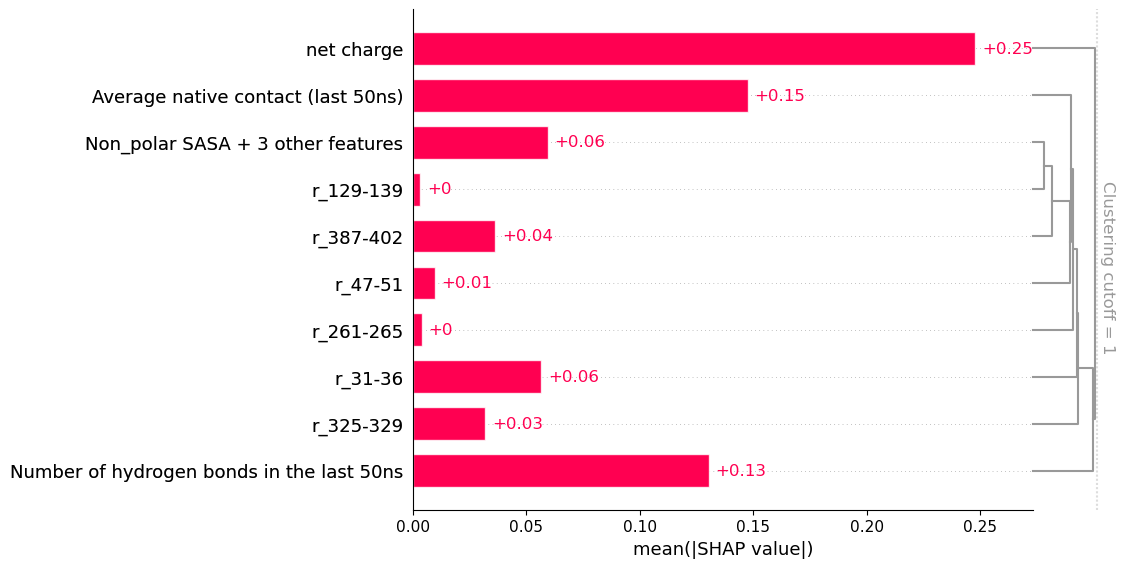

In [7]:
# read file

data = pd.read_excel("mean_rmsf_nc_sasa_agg_total_sasa_temp_hbond_charges_071223.xlsx",index_col=0)

# define X variables

X = data.drop(['Number','temp','IS','pH','Tm','ln(v)','Classifier','mean RMSF'],axis = 1)

# define y varialbe

y = data['Classifier']

model = fit_xgboost(X, y)


import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

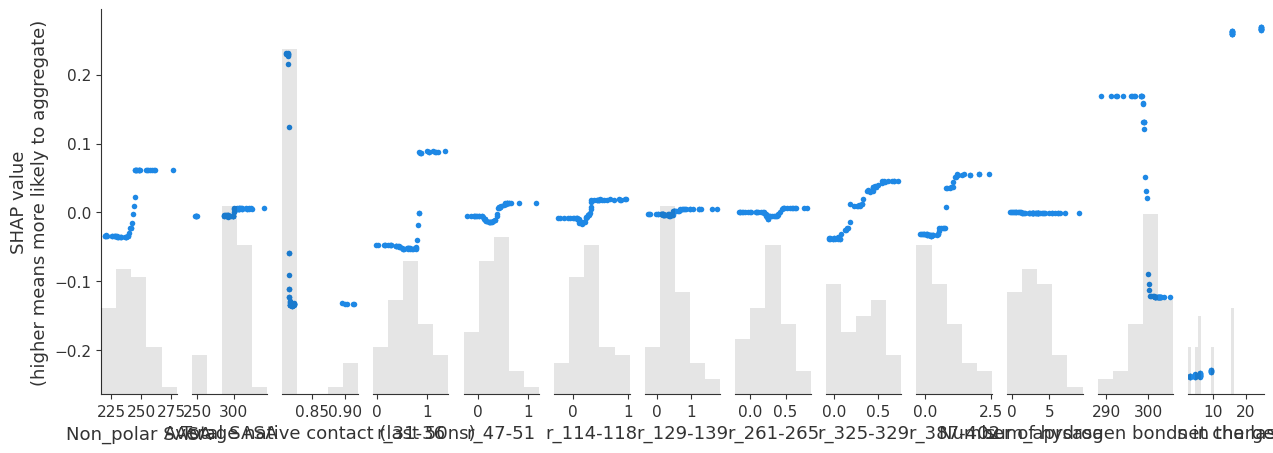

In [8]:
import matplotlib.pyplot as plt

shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to aggregate)")
